## Mumbai House Price Prediction using Linear Regression

In [103]:
# Import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [104]:
# Obtain the modified csv 
data = "../assets/data/modified_mumbai_house_prices.csv"
house_price = pd.read_csv(data)

# Refer assets/scripts/house-price-dataset.py for preprocessing steps

In [105]:
# printing the info for dataset
print(house_price.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75960 entries, 0 to 75959
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   bhk        75960 non-null  int64  
 1   type       75960 non-null  float64
 2   area       75960 non-null  int64  
 3   price      75960 non-null  float64
 4   status     75960 non-null  int64  
 5   age        75960 non-null  float64
 6   latitude   75960 non-null  float64
 7   longitude  75960 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 4.6 MB
None


In [106]:
house_price.head()

,bhk,type,area,price,status,age,latitude,longitude
0,3,0.2,685,2.5000,1,1.0,19.111152,72.842896
1,2,0.2,640,0.5251,0,1.0,19.018051,72.845021
2,2,0.2,610,1.7300,0,1.0,19.155594,72.855254
3,2,0.2,876,0.5998,0,1.0,18.969048,72.821182
4,2,0.2,659,0.9411,0,1.0,19.283337,72.884026


In [107]:
house_price.shape

(75960, 8)

In [108]:
# Define the ratios for train, test, and validation sets
test_ratio = 0.2
val_ratio = 0.1

indices = list(house_price.index)

# Calculate the number of samples for the testing and validation sets
test_size = int(test_ratio * len(house_price))
val_size = int(val_ratio * len(house_price))

# Split the indices into training, testing, and validation sets
test_indices = indices[:test_size]
val_indices = indices[test_size:test_size+val_size]
train_indices = indices[test_size+val_size:]

# Create training, validation, and testing sets
X_train = house_price.loc[train_indices]
X_val = house_price.loc[val_indices]
X_test = house_price.loc[test_indices]

# Extract target variable
y_train = X_train.pop("price").tolist()
y_val = X_val.pop("price").tolist()
y_test = X_test.pop("price").tolist()

print("The size of X_train is: ", X_train.shape)
print("The size of X_val is: ", X_val.shape)
print("The size of X_test is: ", X_test.shape)
print("The size of y_train is: ", len(y_train))
print("The size of y_val is: ", len(y_val))
print("The size of y_test is: ", len(y_test))

The size of X_train is:  (53172, 7)
The size of X_val is:  (7596, 7)
The size of X_test is:  (15192, 7)
The size of y_train is:  53172
The size of y_val is:  7596
The size of y_test is:  15192


In [109]:
X_mean = np.mean(X_train, axis=0)
X_std = np.std(X_train, axis=0)

# Normalizing the data
X_train = (X_train - X_mean)/X_std
X_val = (X_val - X_mean)/X_std
X_test = (X_test - X_mean)/X_std

print(X_train.head())

            bhk      type      area    status       age  latitude  longitude
22788 -0.082017  0.022039  0.035487  0.873397  0.947936 -0.152895   0.075962
22789 -0.082017  0.022039  0.098245  0.873397  0.947936 -0.152895   0.075962
22790 -1.130840  0.022039 -0.494469  0.873397  0.947936 -0.152895   0.075962
22791 -0.082017  0.022039  0.035487  0.873397  0.947936 -0.224314   0.015678
22792 -1.130840  0.022039 -0.543281  0.873397  0.947936 -0.135678   0.068346


In [110]:
W = np.zeros((X_train.shape[1], 1))
b = 0
y_train = np.array(y_train)
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = np.array(y_test)
y_test = y_test.reshape(y_test.shape[0], 1)
y_val = np.array(y_val)
y_val = y_val.reshape(y_val.shape[0], 1)

In [111]:
def fit(X, y, W, b, learning_rate=0.01, num_iterations=1000, l2_lambda=0.01):
    m = X.shape[0]
    total_losses = []

    for i in range(num_iterations):
        Z = np.dot(X, W) + b
        diff = Z - y
        dw = (2/m) * np.dot(X.T, diff) + (l2_lambda / m) * W  # L2 regularization
        db = (2/m) * np.sum(diff)

        W = W - learning_rate * dw
        b = b - learning_rate * db

        loss = (1/m) * np.sum(np.abs(diff))
        regularization_loss = (l2_lambda / (2 * m)) * np.sum(np.square(W))
        total_loss = loss + regularization_loss

        total_losses.append(total_loss)
        
        if i % 100 == 0:
            print("Loss after iteration %i: %f" % (i, total_loss))
        
    return W, b, total_losses

In [112]:
def predict(X, W, b):
    z = np.dot(X, W) + b
    # For all negative values, replace them with 0
    z[z < 0] = 0
    return z

In [113]:
# Tuning hyperparameters using validation set
W, b, total_losses = fit(X_train, y_train, W, b, 0.01, 1000, 0.01)

# Calculate the mean absolute error on validation data in Cr
z = predict(X_val, W, b)
mae = np.sum(np.abs(z - y_val)) / len(y_val)
mse = np.sum(np.square(z - y_val)) / len(y_val)
print(f'Mean absolute error on validation set: {mae}')
print(f'Mean squared error on validation set: {mse}')

# Reset parameters
W = np.zeros((X_train.shape[1], 1))
b = 0

Loss after iteration 0: 1.797079
Loss after iteration 100: 0.785253
Loss after iteration 200: 0.772166
Loss after iteration 300: 0.771390
Loss after iteration 400: 0.771315
Loss after iteration 500: 0.771779
Loss after iteration 600: 0.772456
Loss after iteration 700: 0.773110
Loss after iteration 800: 0.773677
Loss after iteration 900: 0.774121
Mean absolute error on validation set: 0.7362954315179515
Mean squared error on validation set: 1.6602270713629959


In [114]:
# Train on both training and validation data
W, b, total_losses = fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)), W, b)

Loss after iteration 0: 1.769847
Loss after iteration 100: 0.781921
Loss after iteration 200: 0.769210
Loss after iteration 300: 0.768370
Loss after iteration 400: 0.768194
Loss after iteration 500: 0.768663
Loss after iteration 600: 0.769380
Loss after iteration 700: 0.770083
Loss after iteration 800: 0.770688
Loss after iteration 900: 0.771155


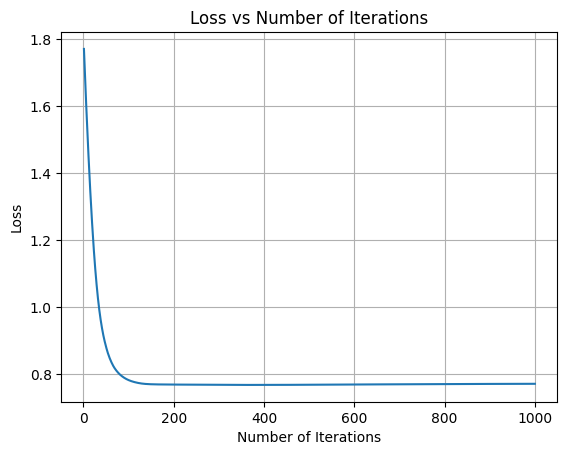

In [115]:
# Plotting missclassifications against the number of iterations
import matplotlib.pyplot as plt
plt.plot(range(1, len(total_losses) + 1), total_losses)
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Number of Iterations')
plt.grid(True)
plt.show()

In [116]:
# Calculate the mean absolute error on test data in Cr
z = predict(X_test, W, b)
mae = np.sum(np.abs(z - y_test)) / len(y_test)
mse = np.sum(np.square(z - y_test)) / len(y_test)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Mean Squared Error: 1.9204643858641945
Mean Absolute Error: 0.6810480162975081


In [117]:
print(W)
print(b)

[[ 0.24808029]
 [-0.06889804]
 [ 1.54944731]
 [-0.18219686]
 [ 0.03142795]
 [ 0.01241904]
 [ 0.01194772]]
1.793029332944521


In [118]:
# Testing with our own data
X_test.loc[0, "bhk"] = 4
X_test.loc[0, "type"] = 0.2
X_test.loc[0, "area"] = 1620
X_test.loc[0, "age"] = 1
X_test.loc[0, "status"] = 1
X_test.loc[0, "latitude"] = 19.1386
X_test.loc[0, "longitude"] = 72.8429

# Normalizing the sample
X_test.loc[0] = (X_test.loc[0] - X_mean) / X_std

z = predict(X_test.loc[0], W, b)
print("The price of house in Cr: ", z)

The price of house in Cr:  [3.38394539]


In [119]:
# Verifying implementation using scikit learn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Initialize the Linear Regression model
model = LinearRegression()
model.fit(np.concatenate((X_train.values, X_val.values)), np.concatenate((y_train, y_val)))
y_pred = model.predict(X_test.values)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error using scikit learn:", mse)
print("Mean Absolute Error using scikit learn:", mae)

Mean Squared Error using scikit learn: 1.9160765129439474
Mean Absolute Error using scikit learn: 0.6833298828316735
